## XGBoost modifications
 - V1 : Use SMOTE

>- import packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix
import joblib 
from pathlib import Path

# for data leveling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

>- Define function & modify

In [2]:
# define ouput dir
output_dir = Path("../output/XGBoost")
output_dir.mkdir(parents=True, exist_ok=True)

output_img_dir = output_dir / "IMG"
output_img_dir.mkdir(parents=True, exist_ok=True)

output_model_dir = output_dir / "model"
output_model_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# Define functions to calculate NDVI and NDWI
def calculate_ndvi(nir, red):
    return (nir - red) / (nir + red + 1e-10)

def calculate_ndwi(nir, green):
    return (nir - green) / (nir + green + 1e-10)

'''
    Enhanced Feature Engineering:
        -  Current features (mean NDVI/NDWI) might be insufficient. Add:

'''
def extract_features(image_path):
    with rasterio.open(image_path) as src:
        bands = src.read()
        nir, red, green = bands[3], bands[0], bands[1]
        
        # Existing features
        ndvi = calculate_ndvi(nir, red)
        ndwi = calculate_ndwi(nir, green)
        
        # New features
        return [
            np.mean(ndvi), np.std(ndvi),  # Add standard deviation
            np.mean(ndwi), np.std(ndwi),
            np.percentile(nir, 75),  # Texture features
            np.mean(green > np.quantile(green, 0.75))  # Threshold features
        ]


>- load dataset with SMOTE

In [4]:
# Load dataset efficiently
train_dataset_path = Path('../../../../data/odm_dataset/Patches/Train')
test_dataset_path = Path('../../../../data/odm_dataset/Patches/Test/')
growth_stages = ["germination", "tillering", "grand_growth", "ripening"]
X, X_test, y, y_test = [], [], [], []

for idx, stage in enumerate(growth_stages):
    stage_path = train_dataset_path / stage
    for img_file in os.listdir(stage_path):
        img_path = stage_path / img_file
        X.append(extract_features(img_path))
        y.append(idx)

X = np.array(X)
y = np.array(y)

# ADD SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

for idx, stage in enumerate(growth_stages):
    stage_path = test_dataset_path / stage
    for img_file in os.listdir(stage_path):
        img_path = stage_path / img_file
        X_test.append(extract_features(img_path))
        y_test.append(idx)

X_test = np.array(X_test)
y_test = np.array(y_test)

>- setup model

In [9]:
# Define parameter grid for XGBoost
param_grid = {
    'learning_rate': [0.1],
    'max_depth': [3],
    'n_estimators': [100],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [5, 10],
    'reg_lambda': [5, 10]
}

# Initialize XGBoost and GridSearchCV
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    tree_method='hist',
    enable_categorical=False,
    min_child_weight=10
)

from sklearn.model_selection import StratifiedKFold
# Stratified K-Fold with fewer splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    xgb_model,
    param_grid,
    cv=skf,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    scoring='accuracy'
)
# Train model with cross-validation
# grid_search.fit(X, y)
grid_search.fit(X_res, y_res)

# Get the best model from Grid Search
best_model = grid_search.best_estimator_

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Train the model on the entire training dataset
eval_set = [(X_res, y_res), (X_test, y_test)]
history = best_model.fit(
    X_res, y_res,
    eval_set=eval_set,
    early_stopping_rounds=5,
    verbose=True
)

# Plot training and test accuracy
eval_results = best_model.evals_result()
train_accuracy = eval_results['validation_0']['mlogloss']
test_accuracy = eval_results['validation_1']['mlogloss']

plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training vs Test Accuracy')
plt.legend()
# plt.savefig(Path(os.path.join(output_img_dir, "ODM_XGB_V11_accuracy_plot.png")))
plt.show()

Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\user\anaconda3\envs\research_env\lib\site-packages\xgboost\core.py:158: UserWarning: [22:04:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 5, 'reg_lambda': 5, 'subsample': 0.8}


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

>- evaluate model

Test Accuracy: 0.7246710842216461
Test Precision: 0.7228690708814867
Test Recall: 0.7246710842216461
Test F1 Score: 0.723007767965122
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.60      0.62      2037
           1       0.70      0.65      0.68      2464
           2       0.79      0.81      0.80      3448
           3       0.72      0.79      0.76      2464

    accuracy                           0.72     10413
   macro avg       0.71      0.71      0.71     10413
weighted avg       0.72      0.72      0.72     10413

Best Cross-Validation Accuracy: 84.54%


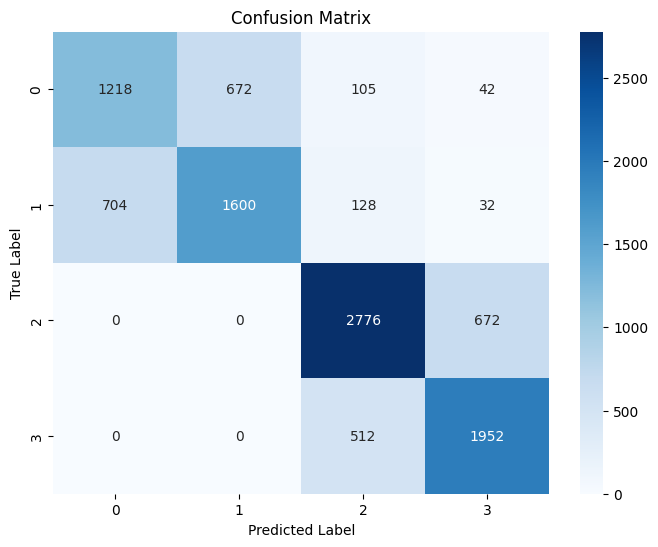

In [10]:
# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

# Calculate additional metrics
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
confusion = confusion_matrix(y_test, y_test_pred)

# Log confusion matrix as an image
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.savefig(Path(os.path.join(output_img_dir, "ODM_XGB_V11_confusion_matrix.png"))) # Save confusion matrix

# Print results
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Classification Report:\n{test_report}")

# Save the best model to disk
XGB_model_v12 = Path(os.path.join(output_model_dir, "XGB_model_v12.joblib"))
# joblib.dump(best_model, XGB_model_v12)
# print(f"Saved model to: {XGB_model_v12}")

# Evaluate using cross-validation accuracy
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")

>- predict

In [13]:
# Load the best model
# model = joblib.load(Path(XGB_model_v12))
model = best_model

def predict_growth_stage(image_path, model):
    features = extract_features(image_path)
    predicted_label = model.predict([features])[0]
    return growth_stages[predicted_label]

new_image = Path('../../../../data/odm_dataset/Patches/Test/ripening/patch_268.tif')
predicted_stage = predict_growth_stage(new_image, model)
print(f"Predicted Growth Stage: {predicted_stage}")
print()

Predicted Growth Stage: ripening



In [14]:
XGB_model_v12 = Path(os.path.join(output_model_dir, "XGB_model_v12.joblib"))
joblib.dump(best_model, XGB_model_v12)
print(f"Saved model to: {XGB_model_v12}")

Saved model to: ..\output\XGBoost\model\XGB_model_v12.joblib
